### **Importing Required Libraries and Loading the Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np

# Load the Dogs vs. Cats dataset
(train_dataset, test_dataset), info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteBZSEEV/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


### **Preprocess the inputs in order to fit the model's input size and be normalized**

In [ ]:
# Preprocessing function to resize and normalize images
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0  # Normalize pixel values
    return image, label


### **Function for Data Augmentation: Done for having better training process**

In [ ]:
# Data augmentation function to apply random transformations
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)

    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.1))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(128, 128))
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    image = random_crop(image)

    return image, label



### **Preprocess the training set and the test set**

In [ ]:
# Preprocess the training and test datasets
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)


### **Apply data augmentation on training set and batch all data**

In [ ]:
# Apply data augmentation only to the training dataset
train_dataset_augmented = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# batch, and prefetch the datasets
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### **Show some examples of the training set**

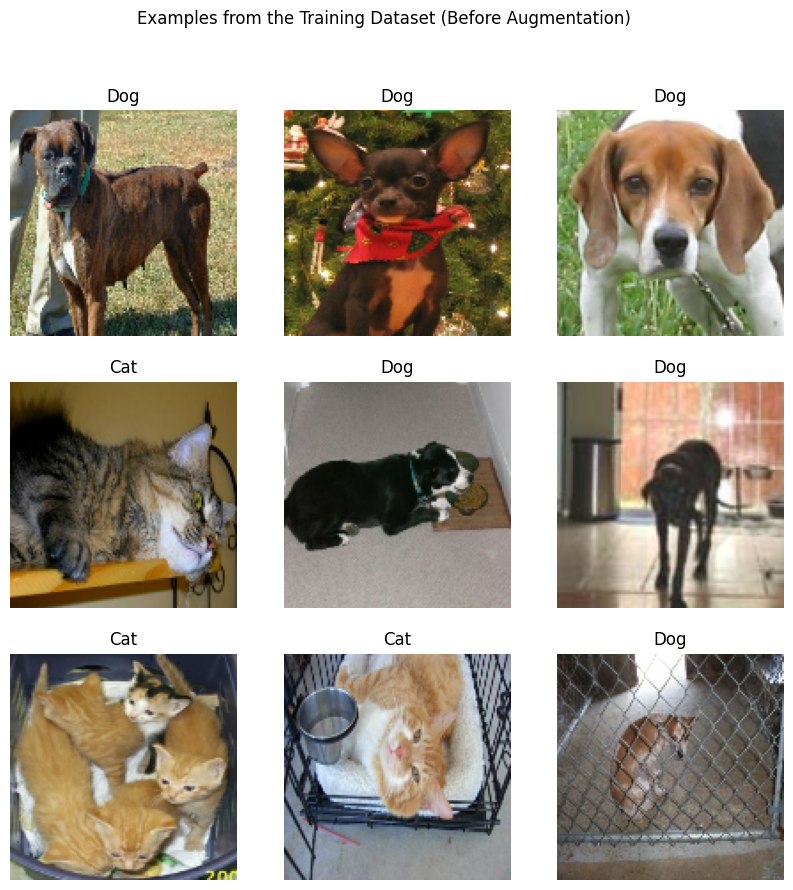

In [ ]:
# Function to display some images from a dataset
def show_examples(dataset, title):
    plt.figure(figsize=(10, 10))
    for batch in dataset.take(1):
        images, labels = batch
        for i in range(min(9, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title('Dog' if labels[i].numpy() == 1 else 'Cat')
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Show some examples from the original training dataset
show_examples(train_dataset.batch(32), "Examples from the Training Dataset (Before Augmentation)")


### **Create the model and give a summary of it**

In [ ]:
# Create the model with L2 regularization and increased dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Display the model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

### **Train model on the training set and validation set**

In [ ]:
# Train the model
history = model.fit(train_dataset_augmented,
                    epochs=20,
                    validation_data=test_dataset,
                    callbacks=[early_stopping])


Epoch 1/20
582/582 [==============================] - 58s 86ms/step - loss: 0.6992 - accuracy: 0.5930 - val_loss: 0.6403 - val_accuracy: 0.6378
Epoch 2/20
582/582 [==============================] - 47s 82ms/step - loss: 0.5946 - accuracy: 0.7013 - val_loss: 0.5218 - val_accuracy: 0.7556
Epoch 3/20
582/582 [==============================] - 54s 92ms/step - loss: 0.5217 - accuracy: 0.7604 - val_loss: 0.4611 - val_accuracy: 0.7990
Epoch 4/20
582/582 [==============================] - 53s 91ms/step - loss: 0.4626 - accuracy: 0.8023 - val_loss: 0.4140 - val_accuracy: 0.8224
Epoch 5/20
582/582 [==============================] - 50s 86ms/step - loss: 0.4265 - accuracy: 0.8203 - val_loss: 0.3838 - val_accuracy: 0.8416
Epoch 6/20
582/582 [==============================] - 48s 82ms/step - loss: 0.3998 - accuracy: 0.8340 - val_loss: 0.3625 - val_accuracy: 0.8474
Epoch 7/20
582/582 [==============================] - 53s 92ms/step - loss: 0.3744 - accuracy: 0.8479 - val_loss: 0.3349 - val_accuracy:

### **Plotting the loss and accuracy of train and validation data**

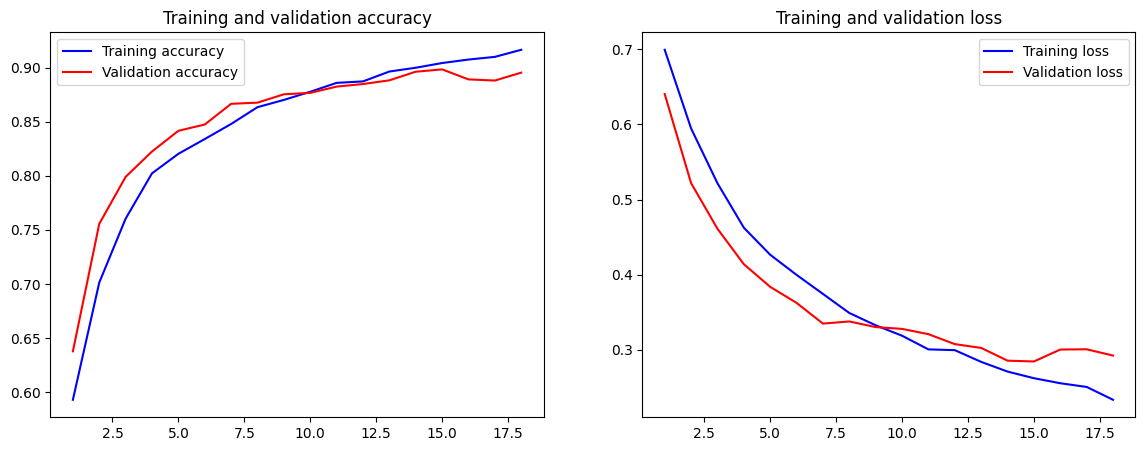

In [ ]:
# Plot training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### **Evaluate the model on test set and print the result**

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

146/146 [==============================] - 9s 60ms/step - loss: 0.2846 - accuracy: 0.8983
Test accuracy: 0.90
